In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.transforms.functional import to_tensor
from torch.amp import autocast, GradScaler

import os
import numpy as np
import subprocess
from PIL import Image
import shutil

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
device = 'cuda'

In [3]:
def read_pickle(path) -> torch.tensor:
    return torch.load(path)

def get_all_file_paths(path) -> list:
    path_list = []
    for top, dirs, files in os.walk(path):
        for nm in files:
            path_list.append(os.path.join(top, nm))
    return path_list

def preload_tensors(path_list, device):
    data = []
    for path in path_list:
        tensor = torch.load(path)  # Load tensor from disk
        video, label = tensor['video'].to(device), tensor['label'].to(device)
        data.append((video.to(torch.float16), label))
    return data

In [4]:
import torch

def save_checkpoint(state, filename="checkpoint.pth"):
    """Save model and optimizer state to a file."""
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth"):
    """Load model and optimizer state from a file."""
    checkpoint = torch.load(filename)
    return checkpoint

In [5]:
class Trainer:
    def __init__(self, model, device, optimizer, loss_fn, scheduler, save=False):
        self.device = device
        self.scaler = GradScaler()  # Automatic Mixed Precision
        self.optimizer = optimizer
        self.scheduler = scheduler  # Add scheduler
        self.loss_fn = loss_fn
        self.model = model
        self.save = save

    def train_step_pickle(self, epoch, preloaded_data):
        self.model.train()
        train_loss, total_correct, total_samples = 0, 0, 0

        for X, y in preloaded_data:
            # Forward pass with AMP
            with autocast('cuda'):
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)
                train_loss += loss.item()

            # Backward pass with scaling
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.optimizer.zero_grad()

            # Accuracy computation
            y_pred_class = torch.argmax(y_pred, dim=1)
            total_correct += (y_pred_class == y).sum().item()
            total_samples += y.size(0)

        acc = total_correct * 100 / total_samples
        train_loss /= len(preloaded_data)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Accuracy: {acc:.2f}")

        # Step scheduler if it's not ReduceLROnPlateau
        if not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step()

    def test_step_pickle(self, epoch,preloaded_data):
        self.model.eval()
        test_loss, acc = 0, 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for X, y in preloaded_data:
                # Use AMP for inference
                with autocast('cuda'):
                    y_pred = self.model(X)
                    loss = self.loss_fn(y_pred, y)
                    test_loss += loss.item()

                # Compute predictions and accuracy
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                total_correct += (y_pred_class == y).sum().item()
                total_samples += y.size(0)

            acc = total_correct * 100 / total_samples
            test_loss = test_loss / len(preloaded_data)
            print(f"Epoch: {epoch} | Test Loss: {test_loss:.4f} | Accuracy: {acc:.2f}")
            
            # Step scheduler if ReduceLROnPlateau
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(test_loss)  # Use validation loss as the metric
            
            if self.save:
                print(f"Saving model at epoch {epoch}...")
                save_checkpoint({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_metric': acc
                }, filename=f"resnet_pretrained_acc={acc:.2f}_loss={loss:.4f}_{epoch=}_real.pth")
            print("************************")


In [6]:
train_preloaded = preload_tensors(get_all_file_paths('/kaggle/input/include-interpolated-300p/ISL_pickle/Train_data'), device='cuda:0')
test_preloaded = preload_tensors(get_all_file_paths('/kaggle/input/include-interpolated-300p/ISL_pickle/Test_data'), device='cuda:0')

<ipython-input-3-2324195e5bc1>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)  # Load tensor from disk


In [33]:
import torch
import torch.nn as nn
from torchvision import models

# CNN + GRU Model with Dropouts
class SignLanguageClassifier(nn.Module):
    def __init__(self, num_classes, dropout):
        super(SignLanguageClassifier, self).__init__()

        # Pre-trained CNN (e.g., ResNet)
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # Remove the final classification layer

        # Dropout after CNN features
        self.cnn_dropout = nn.Dropout(p=dropout)

        # GRU for temporal modeling
        self.gru = nn.GRU(input_size=512, hidden_size=256, num_layers=2, batch_first=True, dropout=0.3)

        # Fully connected layer for classification
        self.fc = nn.Linear(256, num_classes)

        # Dropout before final FC layer
        self.fc_dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        """
        Forward pass for the model.

        Args:
        - x: Input tensor with shape [Batch, Sequence, Channels, Height, Width]

        Returns:
        - output: Model predictions with shape [Batch, Num_Classes]
        """
        batch_size, seq_len, c, h, w = x.size()  # x: [Batch, Sequence, Channels, Height, Width]

        # Reshape input for CNN processing
        x = x.view(batch_size * seq_len, c, h, w)  # Combine Batch and Sequence dimensions: [Batch * Sequence, Channels, Height, Width]

        # Extract features using CNN
        features = self.cnn(x)  # [Batch * Sequence, 512, 1, 1] (ResNet-18 output)
        features = features.view(features.size(0), -1)  # Flatten: [Batch * Sequence, 512]

        # Apply CNN dropout
        features = self.cnn_dropout(features)

        # Reshape features back to sequence format for GRU
        features = features.view(batch_size, seq_len, -1)  # [Batch, Sequence, Features]

        # Pass the sequence of features through the GRU
        gru_out, _ = self.gru(features)  # [Batch, Sequence, Hidden_Size]

        # Take the output of the last time step
        final_output = gru_out[:, -1, :]  # [Batch, Hidden_Size]

        # Apply dropout before the fully connected layer
        final_output = self.fc_dropout(final_output)

        # Pass through the fully connected layer
        output = self.fc(final_output)  # [Batch, Num_Classes]
        return output

In [34]:
shutil.rmtree('/kaggle/working')

OSError: [Errno 16] Device or resource busy: '/kaggle/working'

In [35]:
model = SignLanguageClassifier(num_classes=50, dropout=0.1).to(device)
model = nn.DataParallel(model)  # Distribute model across GPUs

In [36]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define the scheduler without the verbose parameter
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6  # Set a minimum learning rate
)


# Define the loss function
loss_fn = nn.CrossEntropyLoss()


In [37]:
trainer = Trainer(device=device,optimizer=optimizer,loss_fn=loss_fn,save=True,scheduler=scheduler, model=model)
epochs = 100
for epoch in range(epochs):
    trainer.train_step_pickle(epoch=epoch, preloaded_data=train_preloaded)
    trainer.test_step_pickle(epoch=epoch, preloaded_data=test_preloaded)

Epoch: 0 | Train Loss: 3.8951 | Accuracy: 3.23
Epoch: 0 | Test Loss: 3.7288 | Accuracy: 12.99
Saving model at epoch 0...
************************
Epoch: 1 | Train Loss: 3.6198 | Accuracy: 13.06
Epoch: 1 | Test Loss: 3.4468 | Accuracy: 23.38
Saving model at epoch 1...
************************
Epoch: 2 | Train Loss: 3.2818 | Accuracy: 25.25
Epoch: 2 | Test Loss: 3.1158 | Accuracy: 29.87
Saving model at epoch 2...
************************
Epoch: 3 | Train Loss: 2.9209 | Accuracy: 34.83
Epoch: 3 | Test Loss: 2.9107 | Accuracy: 31.60
Saving model at epoch 3...
************************
Epoch: 4 | Train Loss: 2.5814 | Accuracy: 45.52
Epoch: 4 | Test Loss: 2.6227 | Accuracy: 36.36
Saving model at epoch 4...
************************
Epoch: 5 | Train Loss: 2.2649 | Accuracy: 56.47
Epoch: 5 | Test Loss: 2.4071 | Accuracy: 38.53
Saving model at epoch 5...
************************
Epoch: 6 | Train Loss: 1.9712 | Accuracy: 65.80
Epoch: 6 | Test Loss: 2.2028 | Accuracy: 50.65
Saving model at epoch 6.

KeyboardInterrupt: 

<Figure size 100000x100000 with 0 Axes>

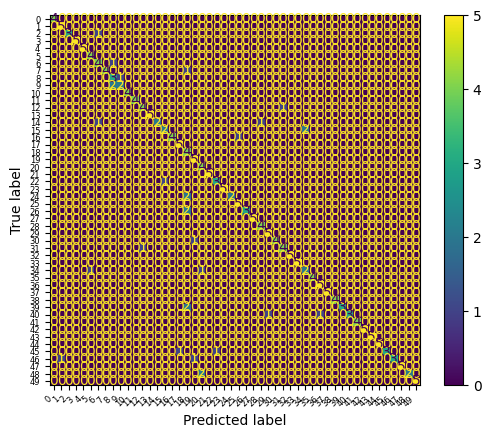

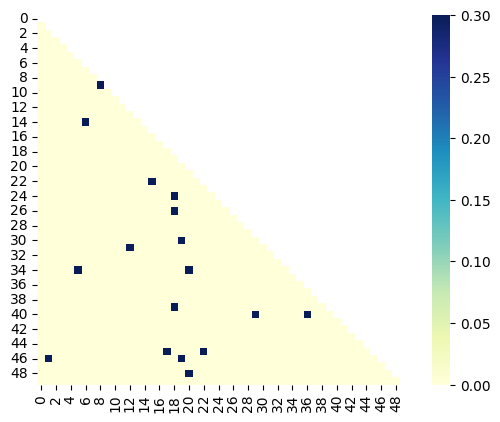

In [38]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.no_grad():
  for X, y in test_preloaded:
    X, y = X.to(device).float(), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())
plt.figure(figsize=(1000, 1000))
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(50))
disp.plot(cmap="viridis")  # Customize colormap if needed
plt.xticks(fontsize=6, rotation=45, ha="right")
plt.yticks(fontsize=6)
plt.show()
import seaborn as sns
def cm_disp(cm):
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cm, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()
cm_disp(cm)

<Figure size 100000x100000 with 0 Axes>

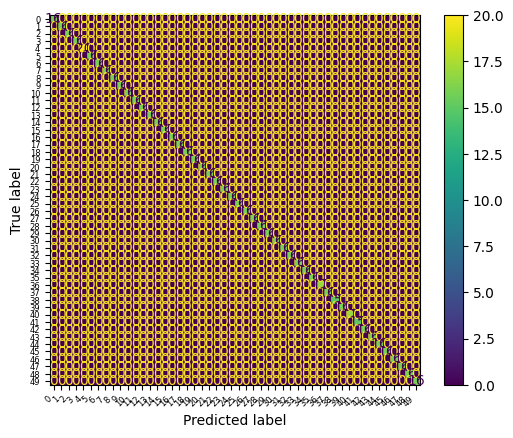

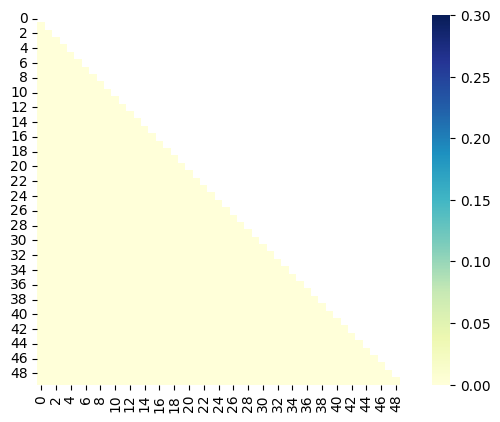

In [39]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.no_grad():
  for X, y in train_preloaded:
    X, y = X.to(device).float(), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())
plt.figure(figsize=(1000, 1000))
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(50))
disp.plot(cmap="viridis")  # Customize colormap if needed
plt.xticks(fontsize=6, rotation=45, ha="right")
plt.yticks(fontsize=6)
plt.show()
import seaborn as sns
def cm_disp(cm):
    mask = np.zeros_like(cm)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cm, mask=mask, vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()
cm_disp(cm)

In [40]:
from IPython.display import FileLink
FileLink('resnet_pretrained_acc=88.74_loss=0.2813_epoch=30_real.pth')

/kaggle/working/resnet_pretrained_acc=88.74_loss=0.2813_epoch=30_real.pth